### Setup

In [51]:
from transformers import SamModel, SamConfig, SamProcessor
import torch, importlib
import cv2, random, os

import format_images

importlib.reload(format_images)
from format_images import format_depth
from format_images import format_images

def get_bounding_box(image_mask):
    
    if np.all(image_mask == 0):
        # If all zeros, create a random bounding box
        H, W = image_mask.shape
        x_min = np.random.randint(0, W)
        x_max = np.random.randint(x_min + 1, W + 1)  # Ensure x_max > x_min
        y_min = np.random.randint(0, H)
        y_max = np.random.randint(y_min + 1, H + 1)  # Ensure y_max > y_min
        
        bbox = [x_min, y_min, x_max, y_max]
    else: 
        if len(image_mask.shape) == 2 or image_mask.shape[2] == 1:
            gray = image_mask
        else:
            gray = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return (0, 0, 0, 0)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        bbox = [x, y, x+w, y+h]
    
    return bbox

from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("./medsam_pretrained/", local_files_only=True)
processor = SamProcessor.from_pretrained("./medsam_pretrained/", local_files_only=True)

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./models/SAM_rgb.pth"))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

train_images, train_masks, val_images, val_masks, test_images, test_masks = format_images()

### Visualize Models

In [31]:
# let's take a random training example
idx = 0

In [32]:
print(len(test_masks))

10


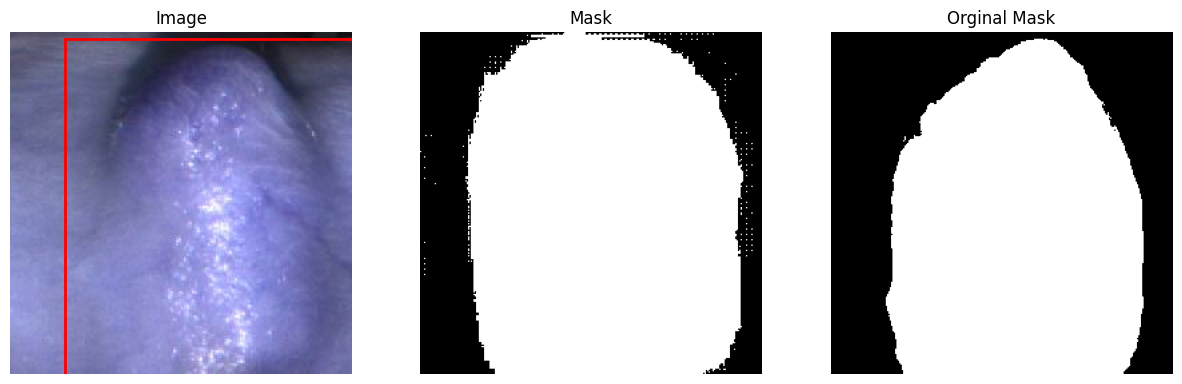

In [36]:

import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# load image
test_image = test_images[idx]

# get box prompt based on ground truth segmentation map
ground_truth_mask = test_masks[idx]

# test bounding box 
#bbox = [0,0,256,256]

pointer_prompt = [100,150]

prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

bbox = prompt
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Mask")

axes[2].imshow(test_masks[idx], cmap = "gray")
axes[2].set_title("Orginal Mask")

for ax in axes:
    ax.axis("off")

# Display the images side by side
plt.show()

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch


def save_images(image_array, image_masks, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in range(len(image_array)):
        # load image
        test_image = image_array[i]
        ground_truth_mask = image_masks[i]
        pointer_prompt = [100, 150]

        prompt = get_bounding_box(ground_truth_mask)

        inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        my_mito_model.eval()

        with torch.no_grad():
            outputs = my_mito_model(**inputs, multimask_output=False)

        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        bbox = prompt
        rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].imshow(np.array(test_image), cmap='gray')
        axes[0].set_title("Image")

        axes[1].imshow(medsam_seg, cmap='gray')
        axes[1].set_title("Predicted Mask")

        axes[2].imshow(ground_truth_mask, cmap='gray')
        axes[2].set_title("Original Mask")

        for ax in axes:
            ax.axis("off")

        fig.savefig(os.path.join(output_dir, f"image_{i}.png"))
        plt.close(fig)  

In [52]:
save_images(test_images, test_masks, './images_MedSAM_rgb')